In [556]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib
import matplotlib.lines as mlines
import pickle as pk

In [557]:
dataset = 'cifar100'
model = 't2t_14'
if dataset == 'cifar10':
    min_acc = 84
    max_acc = 94
if dataset == 'cifar100':
    min_acc = 0
    max_acc = 100

In [558]:
with open(dataset+'_'+model+'/'+dataset+'_boosted_results.pk', 'rb') as file:
        list_dict_boosted = pk.load(file)
        

In [559]:
path = dataset+'_'+model+'/'
list_files = os.listdir(path)
print(list_files)
list_dicts_ours = []
for file_name in list_files:
    if '.pk' in file_name and 'boosted' not in file_name:
        print(file_name)
        with open(os.path.join(path, file_name), 'rb') as file:
            dicts = pk.load(file)
        list_dicts_ours.append(dicts)

['cifar100_0.3_results.pk', 'cifar100.zip', 'cifar100_0.14_results.pk', 'cifar100_0.5_results.pk', 'cifar100_0.6_results.pk', 'cifar100_0.16_results.pk', 'cifar100_0.8_results.pk', 'cifar100_0.1_results.pk', 'cifar100_0.12_results.pk', 'cifar100_boosted_results.pk', 'cifar100_0.01_results.pk', 'cifar100_0.2_results.pk', 'cifar100_0.4_results.pk']
cifar100_0.3_results.pk
cifar100_0.14_results.pk
cifar100_0.5_results.pk
cifar100_0.6_results.pk
cifar100_0.16_results.pk
cifar100_0.8_results.pk
cifar100_0.1_results.pk
cifar100_0.12_results.pk
cifar100_0.01_results.pk
cifar100_0.2_results.pk
cifar100_0.4_results.pk


In [560]:
def extract_metrics_we_want(metrics_dict, keys_we_want):
    metrics_we_want = {}
    for key, val in metrics_dict.items():
        if key in keys_we_want:
            metrics_we_want[key] = val
    return metrics_we_want

def get_all_cov_C(metrics):
    cov_keys = []
    C_keys = []
    for key in metrics.keys():
        if 'cov' in key:
            tokens = key.split('cov')
            alpha = tokens[1]
            prefix = tokens[0]
            cov_key = prefix+'cov'+alpha
            C_key = prefix+'C'+alpha
            cov_keys.append(cov_key)
            C_keys.append(C_key)
    return cov_keys, C_keys

def find_highest_cov(metrics_we_care_about, cov_keys, requested_alpha):
    alpha_max = 0
    for cov_key in cov_keys:
        alpha_val = float(cov_key.split('_')[-1])
        emp_cov = metrics_we_care_about['average'+cov_key]
        #print(emp_cov)
        if 1-emp_cov< requested_alpha:
            if alpha_max < alpha_val:
                alpha_max = alpha_val
                #print('switching fot', alpha_val)
    #print('highest alpha is ', alpha_max, 'with emp cov', )
    return alpha_max
            
        
our_df = pd.DataFrame()
keys_we_want = ['test/acc_exit','test/total_cost', 'test/gated_acc', 'test/gated_ece', 'test/gated_ece']
cov_keys, C_keys = get_all_cov_C(list_dicts_ours[0])
keys_we_want = keys_we_want + cov_keys + C_keys
#print(cov_keys)


In [561]:
for metrics in list_dicts_ours:
    
    metrics_we_care_about = extract_metrics_we_want(metrics, keys_we_want)
    metrics_we_care_about['average_IC'] = np.mean(metrics_we_care_about['test/total_cost'])
    metrics_we_care_about['average_ACC'] = np.mean(metrics_we_care_about['test/gated_acc'])
    for cov_key in cov_keys:
        metrics_we_care_about['average'+cov_key] = np.mean(metrics_we_care_about[cov_key])
        metrics_we_care_about['alpha'+cov_key] = float(cov_key.split('_')[-1]) 
    for C_key in C_keys:
        metrics_we_care_about['average'+C_key] = np.mean(metrics_we_care_about[C_key])
    
    alpha_max = find_highest_cov(metrics_we_care_about, cov_keys, 0.06)
    
    C_key = 'test/C_'+str(alpha_max)
    metrics_we_care_about['C'] = metrics_we_care_about[C_key]
    metrics_we_care_about['emp_alpha'] = alpha_max
    df = pd.DataFrame(data=metrics_we_care_about)
    
    our_df = pd.concat([df, our_df],axis=0, ignore_index=True)

In [562]:
cov_keys, C_keys = get_all_cov_C(list_dict_boosted[0])

boosted_df = pd.DataFrame()
for metrics in list_dict_boosted:
    metrics['average_IC'] = np.mean(metrics['EXPECTED_FLOPS'])
    metrics['average_ACC'] = np.mean(metrics['ACC'])
    for cov_key in cov_keys:
        metrics['average'+cov_key] = np.mean(metrics[cov_key])/100.0
        metrics['alpha'+cov_key] = float(cov_key.split('_')[-1])
    for C_key in C_keys:
        metrics['average'+C_key] = np.mean(metrics[C_key])
    
    alpha_max = find_highest_cov(metrics, cov_keys, 0.05)
   
    if alpha_max >0 :
        C_key = 'C_'+str(alpha_max)
        metrics['C'] = metrics[C_key]
        metrics['emp_alpha'] = alpha_max
    df = pd.DataFrame(data=metrics)
    boosted_df = pd.concat([df, boosted_df],axis=0, ignore_index=True)

In [563]:
filtered_boosted_df = boosted_df[boosted_df['average_ACC'].between(min_acc, max_acc)]
filtered_our_df = our_df[our_df['average_ACC'].between(min_acc, max_acc)]

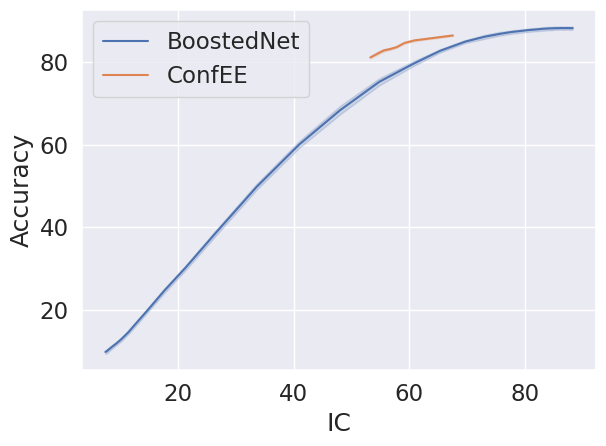

In [564]:
sns.set(font_scale=1.5)  # crazy big

sns.lineplot(data=filtered_boosted_df, x="average_IC", y="ACC", label="BoostedNet")
sns.lineplot(data=filtered_our_df, x="average_IC", y="test/gated_acc", label="ConfEE")
plt.xlabel('IC')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('perf_cost_'+dataset+'.pdf')

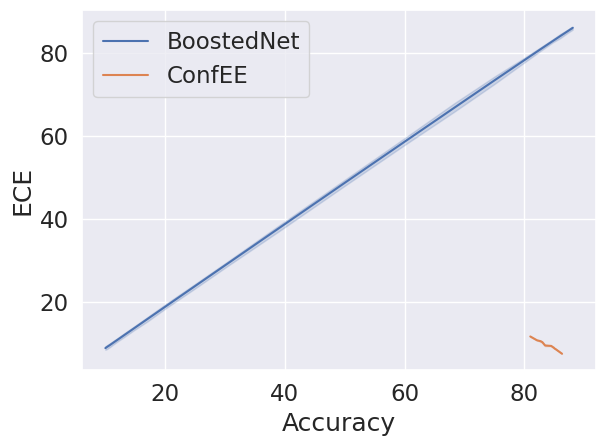

In [565]:
sns.set(font_scale=1.5)  # crazy big

sns.lineplot(data=filtered_boosted_df, x="average_ACC", y="ECE", label="BoostedNet")
sns.lineplot(data=filtered_our_df, x="average_ACC", y="test/gated_ece", label="ConfEE")
plt.xlabel('Accuracy')
plt.ylabel('ECE')
plt.tight_layout()
plt.savefig('perf_ece_'+dataset+'.pdf')

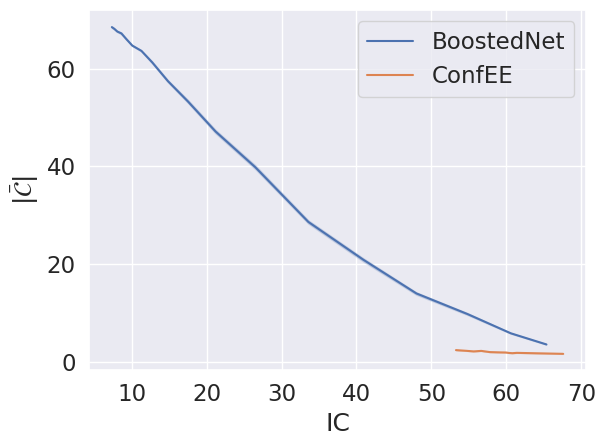

In [566]:
sns.set(font_scale=1.5)  # crazy big

sns.lineplot(data=filtered_boosted_df, x="average_IC", y="C", label="BoostedNet")
sns.lineplot(data=filtered_our_df, x="average_IC", y="C", label="ConfEE")

plt.xlabel('IC')
plt.ylabel(r'$|\mathcal{\bar{C}}|$')
plt.tight_layout()
plt.savefig('inef_IC_'+dataset+'.pdf')


In [534]:
sns.lineplot(data=filtered_our_df, x="alpha", y="emp_alpha", label="ConfEE")
sns.lineplot(data=filtered_boosted_df, x="alpha", y="emp_alpha", label="BoostedNet")

ValueError: Could not interpret value `alpha` for parameter `x`